In [1]:
import json
import math
import os
from datetime import date

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import requests
from IPython.display import Image
from dotenv import load_dotenv
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

In [2]:
load_dotenv()
CLIENT_ID = os.environ.get('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

# Draw Minsk post offices on the map

In [44]:
df_minsk = pd.read_csv('datas/zip_codes_minsk_list.csv')
df_minsk.drop(columns=['Unnamed: 0'], inplace=True)
df_minsk.head()

,address,zip-code,lat,lng
0,"ул. Московская,16",220001,53.887919,27.538119
1,"ул. Сторожевская, 8",220002,53.912949,27.555453
2,"ул. Одинцова, 113",220003,53.900651,27.427532
3,"ул. М.Танка,36, к.2,",220004,53.908628,27.529463
4,"пр. Независимости, 46",220005,53.912815,27.580710


In [4]:
address = 'Minsk, BY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Minsk are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Minsk are 53.902334, 27.5618791.


In [5]:
map_minsk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_minsk['lat'], df_minsk['lng'], df_minsk['zip-code'], df_minsk['address']):
    label = '{}; {}'.format(neighborhood, borough)
    label_f = folium.Popup(label, parse_html=True)
    tooltip = folium.Tooltip(label)
    folium.CircleMarker(
        (lat, lng),
        radius=5,
        popup=label_f,
        tooltip=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_minsk)  
    
map_minsk

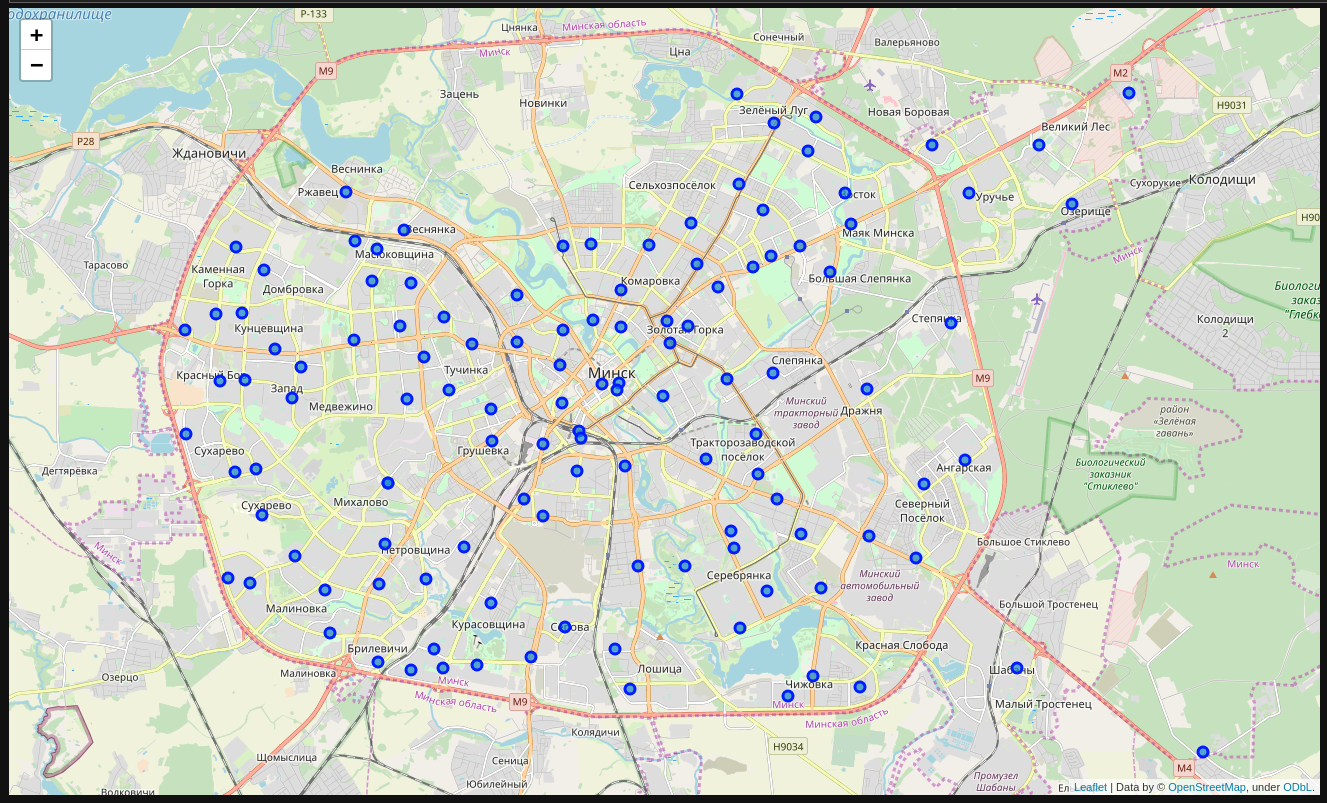

In [45]:
Image('imgs/zip code map minsk.png')

# Find Average distance between data points

In [7]:
def distance(_co: list) -> float:
        """
        wiki - https://...
        r = 6363.513 = for BLR, Minsk; evr. R on Earth = 6378.137 km
        :param _co: [lat A, lng A, lat B, lng B]
        """
        rad_lat_a = math.radians(_co[0])
        rad_lat_b = math.radians(_co[2])
        rad_lng_a = math.radians(_co[1])
        rad_lng_b = math.radians(_co[3])
        central_angle = math.acos(math.sin(rad_lat_a) * math.sin(rad_lat_b) +
                                  math.cos(rad_lat_a) * math.cos(rad_lat_b) * math.cos(rad_lng_a - rad_lng_b))
        r = 6378.137
        dist = r * central_angle  # km
        return dist

In [8]:
all_distances = []
for i in range(df_minsk.shape[0]):
    current_lat = df_minsk.iloc[i, 2]
    current_lng = df_minsk.iloc[i, 3]
    
    for y_lat, y_lng in zip(df_minsk['lat'], df_minsk['lng']):
        min_distance = None
        
        if current_lat != y_lat and current_lng != y_lng:
            current_distance = distance([current_lat, current_lat, y_lat, y_lng])
            
            if min_distance and current_distance < min_distance :
                min_distance = current_distance
            else:
                min_distance = current_distance
        else:
            continue
        
        all_distances.append(min_distance)

l = len(all_distances)
s = sum(all_distances)
avg_distance = s/l
print('list len:', l, ', avg.distance:', avg_distance)

list len: 14760 , avg.distance: 1717.4635539786188


In [9]:
print(None in all_distances, 0.0 in all_distances)
print(min(all_distances), max(all_distances))

False False
1683.9968762290766 1729.7109234822397


# Load data from Foursquare

In [10]:
LIMIT = 100
RADIUS = int(avg_distance / 2)   # meters
VERSION = date.today().strftime("%Y%m%d")
print('RADIUS:', RADIUS, 'm, VERSION:', VERSION)

RADIUS: 858 m, VERSION: 20200201


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, c_lat, c_lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            c_lat, 
            c_lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        with open('foursquare_data_json/data_%s.json' % name, 'w') as outfile:
                json.dump(results, outfile)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            c_lat, 
            c_lng,
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['distance'],
            round(float(v['venue']['location']['lat']), 7), 
            round(float(v['venue']['location']['lng']), 7), 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zip-code',
                             'neighborhood-latitude',
                             'neighborhood-longitude',
                             'venue-id',
                             'venue-name', 
                             'venue-distance', 
                             'venue-latitude', 
                             'venue-longitude', 
                             'venue-category']
    
    return nearby_venues

In [12]:
# minsk_venues = getNearbyVenues(
#     names=df_minsk['zip-code'],
#     latitudes=df_minsk['lat'],
#     longitudes=df_minsk['lng'],
#     radius=RADIUS
# )

# print('minsk_venues - done!')

In [13]:
# minsk_venues.to_csv('datas/minsk_venues.csv')

In [14]:
minsk_venues = pd.read_csv('minsk_venues.csv')
minsk_venues.drop(columns=['Unnamed: 0'], inplace=True)
minsk_venues.head()

,zip-code,neighborhood-latitude,neighborhood-longitude,venue-id,venue-name,venue-distance,venue-latitude,venue-longitude,venue-category
0,220001,53.887919,27.538119,4c8cf10555fba093fdb663ab,Баня № 7,192,53.889164,27.540151,Bath House
1,220001,53.887919,27.538119,55b29ffa498e519a9a539ac1,Hampton by Hilton,408,53.888951,27.544090,Hotel
2,220001,53.887919,27.538119,5b7d910167e5f2002cbaa676,Love Is Muffin,6,53.887880,27.538036,Café
3,220001,53.887919,27.538119,5756af9c498e47bf24348c6f,ціКава,358,53.888720,27.543410,Coffee Shop
4,220001,53.887919,27.538119,53653dee498ec5bdccef681a,Renaissance Minsk Hotel,794,53.892496,27.528823,Hotel


In [15]:
minsk_venues.shape

(4049, 9)

# Clean data, delete duplicated

### from duplicate data get field only with closest distance to a neighborhood center

In [16]:
%%time
venues_to_save = []
venues_to_save_ids = []
venues_category_to_delete = ['Trail','Bus Stop','Bus Station','Moving Target','Bus Line','Platform']

for index, venue_id in enumerate(minsk_venues['venue-id']):
    if (index not in venues_to_save_ids) and (minsk_venues.iloc[index, 8] not in venues_category_to_delete):

        venue_id_list = minsk_venues.index[minsk_venues['venue-id'] == venue_id].tolist()

        if len(venue_id_list) > 1:
            venue_distance = [minsk_venues.iloc[vl, 5] for vl in venue_id_list]

            min_dist_index = venue_distance.index(min(venue_distance))
            save_venue_index = venue_id_list[min_dist_index]
            
            if (save_venue_index not in venues_to_save_ids) and (minsk_venues.iloc[save_venue_index, 8] not in venues_category_to_delete):
                venues_to_save_ids.append(save_venue_index)
                save_venue = minsk_venues.iloc[save_venue_index, :].to_list()
                venues_to_save.append(save_venue)

            venue_distance = []
        elif len(venue_id_list) == 1:
            venues_to_save_ids.append(index)
            venues_to_save.append(minsk_venues.iloc[index, :].to_list())


CPU times: user 2.9 s, sys: 10.9 ms, total: 2.91 s
Wall time: 2.94 s


In [17]:
print(len(venues_to_save), len(venues_to_save_ids))

2187 2187


In [18]:
df_columns = ['zip-code','neighborhood-latitude','neighborhood-longitude','venue-id', 
              'venue-name', 'venue-distance', 'venue-latitude', 'venue-longitude', 'venue-category']
minsk_venues = pd.DataFrame(data=venues_to_save, columns=df_columns)
minsk_venues

,zip-code,neighborhood-latitude,neighborhood-longitude,venue-id,venue-name,venue-distance,venue-latitude,venue-longitude,venue-category
0,220001,53.887919,27.538119,4c8cf10555fba093fdb663ab,Баня № 7,192,53.889164,27.540151,Bath House
1,220001,53.887919,27.538119,55b29ffa498e519a9a539ac1,Hampton by Hilton,408,53.888951,27.544090,Hotel
2,220001,53.887919,27.538119,5b7d910167e5f2002cbaa676,Love Is Muffin,6,53.887880,27.538036,Café
3,220001,53.887919,27.538119,5756af9c498e47bf24348c6f,ціКава,358,53.888720,27.543410,Coffee Shop
4,220036,53.895040,27.520366,53653dee498ec5bdccef681a,Renaissance Minsk Hotel,622,53.892496,27.528823,Hotel
...,...,...,...,...,...,...,...,...,...
2182,220141,53.938677,27.684619,5027750ae4b0d14d95d056fc,Баден,663,53.944484,27.686921,Shoe Store
2183,220141,53.938677,27.684619,52bdba5d498e5e4c09b2fb84,Yves Rocher,773,53.935956,27.673765,Cosmetics Shop
2184,220141,53.938677,27.684619,5333f04e11d2f0d39e7455da,Rieker,783,53.936630,27.673185,Shoe Store
2185,220141,53.938677,27.684619,598433e54aa3f811584aab30,Мила,844,53.945940,27.688341,Cosmetics Shop


In [19]:
venues_id = minsk_venues['venue-id']
minsk_venues[venues_id.isin(venues_id[venues_id.duplicated()])]

,zip-code,neighborhood-latitude,neighborhood-longitude,venue-id,venue-name,venue-distance,venue-latitude,venue-longitude,venue-category


In [20]:
# minsk_venues.index[minsk_venues['venue-id'] == '4f7abb0be4b0ddbcd476725a'].tolist()

In [21]:
# minsk_venues.sort_values('zip-code', inplace=True)
# minsk_venues.drop_duplicates(subset='venue-id', keep='first', inplace=True)
# minsk_venues.reset_index(inplace=True)
# minsk_venues

In [22]:
print('There are {} uniques categories.'.format(len(minsk_venues['venue-category'].unique())))

There are 310 uniques categories.


In [23]:
# minsk_venues.to_csv('datas/minsk_venues_filtered.csv')

# Analyze Each Neighborhood

In [24]:
# one hot encoding
minsk_onehot = pd.get_dummies(minsk_venues[['venue-category']], prefix="", prefix_sep="")

# add neighborhood column back to data-frame
minsk_onehot['zip-code'] = minsk_venues['zip-code'] 

# move neighborhood column to the first column
fixed_columns = [minsk_onehot.columns[-1]] + list(minsk_onehot.columns[:-1])
minsk_onehot = minsk_onehot[fixed_columns]

minsk_onehot.head()

,zip-code,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,220001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,220036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
minsk_grouped = minsk_onehot.groupby('zip-code').mean().reset_index()
print(minsk_grouped.shape)
minsk_grouped.head()

(121, 311)


,zip-code,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,220001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,220002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.0,0.0
2,220003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
3,220004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.058824,0.0,0.0,0.000000,0.0,0.0
4,220005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.028571,0.000000,0.0,0.0,0.000000,0.0,0.0


### sort the venues in descending order

In [26]:
def return_most_common_venues(row, _num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:_num_top_venues]

### create the new data-frame and display the top 10 venues for each neighborhood

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zip-code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new data-frame
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['zip-code'] = minsk_grouped['zip-code']

for ind in np.arange(minsk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minsk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,220001,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio,Doner Restaurant,Beer Bar,Science Museum,Bath House,Theater,Metro Station
1,220002,Gym,Scenic Lookout,Arts & Crafts Store,Karaoke Bar,Buffet,Theater,Basketball Court,Beer Store,Belarusian Restaurant,Spa
2,220003,Department Store,Furniture / Home Store,Café,Park,Fishing Store,Supermarket,Food & Drink Shop,Flower Shop,Food,Fish Market
3,220004,Gym,Clothing Store,Café,Wine Shop,Concert Hall,Gift Shop,Shopping Mall,Electronics Store,Bakery,Casino
4,220005,Coffee Shop,Cosmetics Shop,Auto Garage,Hostel,Café,Temple,Tea Room,Fountain,Miscellaneous Shop,Bookstore


# Cluster Neighborhoods

### Run k-means to cluster the neighborhood into 5 clusters

In [28]:
# set number of clusters
kclusters = 5

minsk_grouped_clustering = minsk_grouped.drop('zip-code', 1)

# run k-means clustering
# random_state=0
# n_init=30
# init="k-means++"
kmeans = KMeans(n_clusters=kclusters, n_init=30).fit(minsk_grouped_clustering)

# check cluster labels generated for each row in the data-frame
kmeans.labels_[:10]

array([2, 2, 4, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

### new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster-label', kmeans.labels_)

minsk_merged = df_minsk

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
minsk_merged = minsk_merged.join(neighborhoods_venues_sorted.set_index('zip-code'), on='zip-code')

In [30]:
minsk_merged.head()

,address,zip-code,lat,lng,cluster-label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"ул. Московская,16",220001,53.887919,27.538119,2.0,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio,Doner Restaurant,Beer Bar,Science Museum,Bath House,Theater,Metro Station
1,"ул. Сторожевская, 8",220002,53.912949,27.555453,2.0,Gym,Scenic Lookout,Arts & Crafts Store,Karaoke Bar,Buffet,Theater,Basketball Court,Beer Store,Belarusian Restaurant,Spa
2,"ул. Одинцова, 113",220003,53.900651,27.427532,4.0,Department Store,Furniture / Home Store,Café,Park,Fishing Store,Supermarket,Food & Drink Shop,Flower Shop,Food,Fish Market
3,"ул. М.Танка,36, к.2,",220004,53.908628,27.529463,2.0,Gym,Clothing Store,Café,Wine Shop,Concert Hall,Gift Shop,Shopping Mall,Electronics Store,Bakery,Casino
4,"пр. Независимости, 46",220005,53.912815,27.580710,2.0,Coffee Shop,Cosmetics Shop,Auto Garage,Hostel,Café,Temple,Tea Room,Fountain,Miscellaneous Shop,Bookstore


### delete rows with 'nan' values, and transform 'Cluster Labels' to int type

In [31]:
minsk_merged.isnull().sum()

address                   0
zip-code                  0
lat                       0
lng                       0
cluster-label             1
1st Most Common Venue     1
2nd Most Common Venue     1
3rd Most Common Venue     1
4th Most Common Venue     1
5th Most Common Venue     1
6th Most Common Venue     1
7th Most Common Venue     1
8th Most Common Venue     1
9th Most Common Venue     1
10th Most Common Venue    1
dtype: int64

In [32]:
minsk_merged.dropna(inplace=True)
minsk_merged['cluster-label'] = minsk_merged['cluster-label'].astype(int)
minsk_merged['cluster-label'].value_counts()

2    95
0    16
4     8
3     1
1     1
Name: cluster-label, dtype: int64

In [33]:
print(minsk_merged.shape)
minsk_merged.head()

(121, 15)


,address,zip-code,lat,lng,cluster-label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"ул. Московская,16",220001,53.887919,27.538119,2,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio,Doner Restaurant,Beer Bar,Science Museum,Bath House,Theater,Metro Station
1,"ул. Сторожевская, 8",220002,53.912949,27.555453,2,Gym,Scenic Lookout,Arts & Crafts Store,Karaoke Bar,Buffet,Theater,Basketball Court,Beer Store,Belarusian Restaurant,Spa
2,"ул. Одинцова, 113",220003,53.900651,27.427532,4,Department Store,Furniture / Home Store,Café,Park,Fishing Store,Supermarket,Food & Drink Shop,Flower Shop,Food,Fish Market
3,"ул. М.Танка,36, к.2,",220004,53.908628,27.529463,2,Gym,Clothing Store,Café,Wine Shop,Concert Hall,Gift Shop,Shopping Mall,Electronics Store,Bakery,Casino
4,"пр. Независимости, 46",220005,53.912815,27.580710,2,Coffee Shop,Cosmetics Shop,Auto Garage,Hostel,Café,Temple,Tea Room,Fountain,Miscellaneous Shop,Bookstore


In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
# x = np.arange(kclusters)
# ys = [i + x + (i*x)**2 for i in range(kclusters)]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = ['blue', 'purple', 'grey', 'red', 'green']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minsk_merged['lat'], minsk_merged['lng'], 
                                  minsk_merged['zip-code'], minsk_merged['cluster-label']):
    label_text = str(poi) + ' Cluster ' + str(cluster)
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        (lat, lon),
        radius=5,
        popup=label,
        tooltip=label_text,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
        
map_clusters

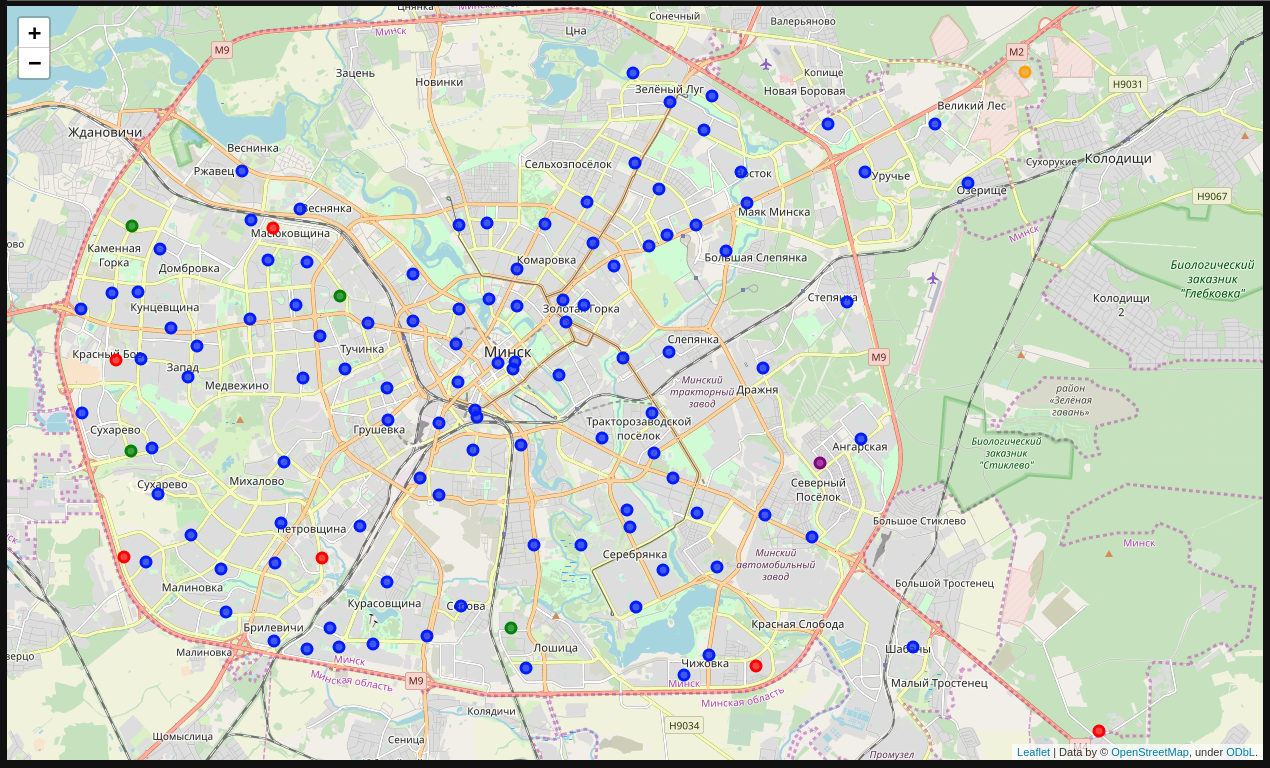

In [43]:
Image('imgs/minsk_clusters_map_AVG.png')

# Clasters 

In [36]:
minsk_merged['cluster-label'].value_counts()

2    95
0    16
4     8
3     1
1     1
Name: cluster-label, dtype: int64

### Cluster 0

In [37]:
minsk_merged.loc[minsk_merged['cluster-label'] == 0, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,220015,Auto Garage,Department Store,Park,Pub,Cosmetics Shop,Grocery Store,Intersection,Coffee Shop,Dog Run,Tailor Shop
30,220031,Park,Vegetarian / Vegan Restaurant,Zoo Exhibit,Duty-free Shop,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant
32,220033,Cafeteria,Grocery Store,Pizza Place,Food & Drink Shop,Farmers Market,Park,Bath House,Gas Station,Go Kart Track,Café
49,220051,Cosmetics Shop,Park,Auto Garage,Coffee Shop,Dance Studio,Office,Dog Run,Tennis Stadium,Zoo Exhibit,Farmers Market
62,220064,Auto Garage,Train Station,Pizza Place,Zoo Exhibit,Falafel Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
64,220066,Grocery Store,Clothing Store,Hotel,Ethiopian Restaurant,Hockey Arena,Pizza Place,Market,Park,Fabric Shop,Eastern European Restaurant
74,220077,Caucasian Restaurant,Food & Drink Shop,Pharmacy,Fish Market,Fast Food Restaurant,Deli / Bodega,Park,Paper / Office Supplies Store,Pizza Place,Eye Doctor
84,220093,Pizza Place,Pharmacy,Indie Theater,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop
89,220099,Pizza Place,Gourmet Shop,Food & Drink Shop,Auto Garage,Cafeteria,Buffet,Health Food Store,Zoo Exhibit,Ethiopian Restaurant,Event Space
91,220101,Cosmetics Shop,Tennis Court,Park,River,Tram Station,Athletics & Sports,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor


### Cluster 1

In [38]:
minsk_merged.loc[minsk_merged['cluster-label'] == 1, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
55,220057,Music Venue,Basketball Court,Zoo Exhibit,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market


### Cluster 2

In [39]:
minsk_merged.loc[minsk_merged['cluster-label'] == 2, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,220001,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio,Doner Restaurant,Beer Bar,Science Museum,Bath House,Theater,Metro Station
1,220002,Gym,Scenic Lookout,Arts & Crafts Store,Karaoke Bar,Buffet,Theater,Basketball Court,Beer Store,Belarusian Restaurant,Spa
3,220004,Gym,Clothing Store,Café,Wine Shop,Concert Hall,Gift Shop,Shopping Mall,Electronics Store,Bakery,Casino
4,220005,Coffee Shop,Cosmetics Shop,Auto Garage,Hostel,Café,Temple,Tea Room,Fountain,Miscellaneous Shop,Bookstore
5,220006,Coffee Shop,Pharmacy,Soccer Field,Rental Car Location,Athletics & Sports,Photography Lab,Nightclub,Food & Drink Shop,Sports Bar,Bike Trail
...,...,...,...,...,...,...,...,...,...,...,...
113,220127,Hotel,Stadium,Café,Gym / Fitness Center,Ski Area,Park,Plaza,Eastern European Restaurant,Zoo Exhibit,Eye Doctor
116,220134,Gym / Fitness Center,Coffee Shop,Pizza Place,IT Services,Rock Club,Clothing Store,Park,Café,Spa,Lingerie Store
117,220136,Bookstore,Café,Wine Shop,Lake,Flower Shop,Pet Store,Fast Food Restaurant,Pizza Place,Gourmet Shop,Beer Store
120,220140,Cosmetics Shop,Sushi Restaurant,Gym / Fitness Center,Casino,Doner Restaurant,Spa,Supermarket,Flower Shop,Fried Chicken Joint,Café


### Cluster 3

In [40]:
minsk_merged.loc[minsk_merged['cluster-label'] == 3, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,220078,Salsa Club,Arcade,Fast Food Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market


### Cluster 4

In [41]:
minsk_merged.loc[minsk_merged['cluster-label'] == 4, minsk_merged.columns[[1] + list(range(5, minsk_merged.shape[1]))]]

,zip-code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,220003,Department Store,Furniture / Home Store,Café,Park,Fishing Store,Supermarket,Food & Drink Shop,Flower Shop,Food,Fish Market
26,220027,Café,Park,Zoo Exhibit,Farmers Market,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Fast Food Restaurant
43,220044,Café,Food & Drink Shop,Big Box Store,Department Store,Zoo Exhibit,Fast Food Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant
85,220094,Café,Department Store,Fast Food Restaurant,Park,Grocery Store,Pet Store,Scenic Lookout,Pizza Place,Big Box Store,Supermarket
87,220096,Department Store,Liquor Store,Supermarket,Café,Wine Shop,Park,Farmers Market,Ethiopian Restaurant,Event Space,Eye Doctor
88,220098,Department Store,Food & Drink Shop,Movie Theater,Shopping Mall,Food Court,Food Service,Food,Flower Shop,Fishing Store,Fish Market
97,220109,Department Store,Kosher Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
114,220128,Track,Dive Bar,Department Store,Zoo Exhibit,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant


In [42]:
# minsk_merged.to_csv('datas/minsk_cluster.csv')

# Done